In [28]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  5 09:46:49 2018
@author: Lucas de Moura Rodrigues
@ra: 14.00556-5
"""

'\nCreated on Wed Sep  5 09:46:49 2018\n@author: Lucas de Moura Rodrigues\n@ra: 14.00556-5\n'

In [47]:
import time
import numpy as np
import pandas as pd
from sklearn import linear_model,metrics,svm, preprocessing, ensemble, model_selection
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
tempo_inicial = time.time()

In [49]:
# le o csv
print('Le e trata os dados: ', round(time.time() - tempo_inicial, 3))
precos_casa = pd.read_csv("precos_casa_california.csv")

Le e trata os dados:  0.175


In [50]:
#analisa os dados do csv
precos_casa.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.25,37.85,52.0,919.0,,413.0,,4.0368,269700.0,NEAR BAY
2,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [51]:
# ve as informacoes (estatistica) do Dataframe
precos_casa.describe()

,latitude,median_income
count,20445.000000,20444.000000
mean,35.643596,3.876869
std,2.129236,1.904054
min,32.540000,0.499900
25%,33.940000,2.565750
50%,34.260000,3.540300
75%,37.720000,4.756600
max,41.950000,15.000100


In [52]:
# ve as informacoes (estrutura) do Dataframe
precos_casa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20445 entries, 0 to 20444
Data columns (total 10 columns):
longitude             20445 non-null object
latitude              20445 non-null float64
housing_median_age    20445 non-null object
total_rooms           20445 non-null object
total_bedrooms        20241 non-null object
population            20445 non-null object
households            20445 non-null object
median_income         20444 non-null float64
median_house_value    20445 non-null object
ocean_proximity       20445 non-null object
dtypes: float64(2), object(8)
memory usage: 1.6+ MB


In [53]:
# trata o dataframe, tirando outliers e espacos em branco
precos_casa = precos_casa.replace(' ', np.nan)
precos_casa = precos_casa.dropna()
colunas = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
for i in colunas:
    precos_casa[i] = pd.to_numeric(precos_casa[i])
    precos_casa = precos_casa.loc[precos_casa[i] < precos_casa[i].quantile(0.95)]
precos_casa = precos_casa.reset_index(drop=True)

In [54]:
precos_casa.describe()

,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,13930.000000,13930.000000,13930.000000,13930.000000,13930.000000,13930.000000,13930.000000,13930.000000
mean,35.694599,28.550323,1955.799282,400.786935,1097.638335,374.421608,3.515953,173585.886360
std,2.181956,11.149611,918.063132,174.487808,492.718730,160.755241,1.377513,80856.189371
min,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,0.000000
25%,33.930000,19.000000,1307.250000,275.000000,744.000000,261.000000,2.453700,108000.000000
50%,34.300000,30.000000,1851.000000,387.000000,1057.000000,364.000000,3.360700,162500.000000
75%,37.720000,36.000000,2529.000000,520.000000,1431.000000,488.000000,4.440525,226500.000000
max,41.950000,51.000000,5989.000000,994.000000,2400.000000,735.000000,7.358800,387500.000000


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


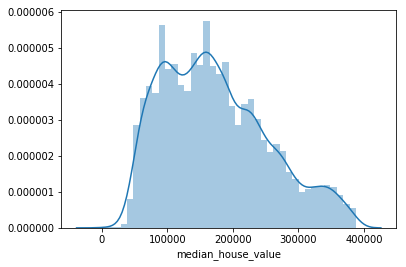

In [55]:
# plota 
sns.distplot(precos_casa['median_house_value'])

In [38]:
# separa o dataframe
features = precos_casa.loc[:, precos_casa.columns != 'median_house_value']
target = precos_casa.loc[:, precos_casa.columns == 'median_house_value']

In [39]:
# numeriza o ocean
dic_ocean = {0: 'NEAR BAY', 1: '<1H OCEAN', 2: 'INLAND', 3: 'NEAR OCEAN', 4: 'ISLAND'}
for chave, valor in dic_ocean.items():
    features = features.replace(valor, chave)

In [40]:
features.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,0
1,-122.26,37.85,50.0,1120.0,283.0,697.0,264.0,2.1250,0
2,-122.26,37.84,50.0,2239.0,455.0,990.0,419.0,1.9911,0


In [41]:
# normaliza dados
colunas = features.columns
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(features.values.astype(float))
features = pd.DataFrame(x_scaled)
features.columns = colunas

#normaliza target
colunas = target.columns
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(target.values.astype(float))
target = pd.DataFrame(x_scaled)
target.columns = colunas

In [42]:
features.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,0.207951,0.563231,0.82,0.426424,0.668347,0.501877,0.809004,0.230431,0.0
1,0.207951,0.564293,0.98,0.186738,0.283266,0.289529,0.357435,0.236933,0.0
2,0.207951,0.563231,0.98,0.373643,0.456653,0.411765,0.568895,0.217411,0.0


In [483]:
target.head(3)

,median_house_value
0,0.585032
1,0.361290
2,0.409548


In [56]:
# separa o dataframe: dados_treino = 0 - 40%  dados_validacao = 40 - 100%
features_treino, features_teste, target_treino, target_teste = model_selection.train_test_split(features, target, test_size=0.4, random_state=101)

In [57]:
features_treino.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
8504,0.986748,0.114772,0.50,0.002672,0.001008,0.000834,0.001364,0.005263,0.50
5215,0.618756,0.146652,0.62,0.289460,0.431452,0.707551,0.523874,0.099054,0.25
307,0.226300,0.546227,0.72,0.141306,0.201613,0.129746,0.276944,0.276415,0.00


In [58]:
features_teste.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13884,0.240571,0.674814,0.28,0.243862,0.314516,0.321652,0.366985,0.298576,0.50
4910,0.622834,0.160468,0.68,0.216135,0.307460,0.592407,0.373806,0.327064,0.25
12413,0.199796,0.853348,0.46,0.268582,0.307460,0.310805,0.416098,0.314803,0.50


In [59]:
target_treino.head()

,median_house_value
8504,0.709677
5215,0.267871
307,0.492387
925,0.598968
4619,0.663742


In [60]:
target_teste.head()

,median_house_value
13884,0.236645
4910,0.348903
12413,0.213677
4088,0.419355
4728,0.765677


In [67]:
# machine learning
print('Predicao dos Dados: ', round(time.time() - tempo_inicial, 3))
#clf = linear_model.LassoLars(alpha=.1)  # 25480756266.08841
#clf = linear_model.Ridge (alpha = .5) # 25490381018.173256
#clf = svm.SVR() # 6922054605.659882
clf = ensemble.BaggingRegressor()
#clf = linear_model.SGDRegressor() # infinito
clf.fit(features_treino.values, target_treino.values.ravel())
predicao = clf.predict(features_teste)

Predicao dos Dados:  407.819


In [68]:
predicao

array([0.34461935, 0.36505806, 0.21104516, ..., 0.19869677, 0.51762581,
       0.44887742])

In [69]:
# array -> dataframe
predicao = [float(i) for i in predicao]
predicao = pd.DataFrame(data=predicao,columns=['median_house_value']).reset_index(drop=True)
predicao.head()

,median_house_value
0,0.344619
1,0.365058
2,0.211045
3,0.571019
4,0.573032


In [70]:
sklearn.metrics.mean_squared_error(target_teste, predicao)

0.011130228239545676

In [71]:
clf.score(features_teste, target_teste)

0.74574084330342

In [74]:
clf.score(features_treino, target_treino)

0.9558183243862793

In [76]:
# cria um dataframe para comparar os dados e confirmar se fiz sertu
print('Comparando os Dados: ', round(time.time() - tempo_inicial, 3))
resultado = target_teste.reset_index(drop=True).copy()
resultado['predicao'] = predicao['median_house_value']
resultado = resultado.rename(index=str, columns={'median_house_value': 'Valor Correto', 'predicao': 'Valor_Calculado'})
resultado['Diferenca_Absoluta'] = resultado['Valor Correto'] - resultado['Valor_Calculado']
resultado['Diferenca_Porcentagem'] = (resultado['Valor Correto'] / resultado['Valor_Calculado'] - 1) * 100
resultado.head()

Comparando os Dados:  562.711


,Valor Correto,Valor_Calculado,Diferenca_Absoluta,Diferenca_Porcentagem
0,0.236645,0.344619,-0.107974,-31.331436
1,0.348903,0.365058,-0.016155,-4.425279
2,0.213677,0.211045,0.002632,1.247249
3,0.419355,0.571019,-0.151665,-26.560311
4,0.765677,0.573032,0.192645,33.618554


In [496]:
# salva o resultado em um excel
excel = pd.ExcelWriter(F"Resultado.xlsx")
precos_casa.to_excel(excel, sheet_name='Precos_Casa_Tratado')
resultado.to_excel(excel, sheet_name='Comparacao')
excel.save()

In [497]:
print('Tempo do Programa: ', round(time.time() - tempo_inicial, 3))

Tempo do Programa:  5.387
